In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 작업 디렉토리 설정
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')


Mounted at /content/drive


In [2]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 2. / 2. # case: 1 point
        density += scipy.ndimage.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [4]:
#set the root to the Shanghai dataset you download
root = '.'

In [5]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [8]:
# Define the gaussian_filter_density function if not already defined
def gaussian_filter_density(k):
    # Define your Gaussian filtering logic here
    return gaussian_filter(k, sigma=15)  # Example: adjust sigma based on your requirement

# Assume img_paths is a list of image paths
for img_path in img_paths:
    print(img_path)  # Updated for Python 3 compatibility

    # Load the .mat file
    mat_path = img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_')
    mat = io.loadmat(mat_path)

    # Load the image
    img = plt.imread(img_path)

    # Initialize density map
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["image_info"][0, 0][0, 0][0]

    # Populate the density map
    for i in range(len(gt)):
        y, x = int(gt[i][1]), int(gt[i][0])  # Extract coordinates
        if y < img.shape[0] and x < img.shape[1]:
            k[y, x] = 1

    # Apply Gaussian filter
    k = gaussian_filter_density(k)

    # Save the density map as .h5 file
    h5_path = img_path.replace('.jpg', '.h5').replace('images', 'ground_truth')
    with h5py.File(h5_path, 'w') as hf:
        hf['density'] = k


./part_A_final/train_data/images/IMG_213.jpg
./part_A_final/train_data/images/IMG_212.jpg
./part_A_final/train_data/images/IMG_211.jpg
./part_A_final/train_data/images/IMG_210.jpg
./part_A_final/train_data/images/IMG_21.jpg
./part_A_final/train_data/images/IMG_209.jpg
./part_A_final/train_data/images/IMG_208.jpg
./part_A_final/train_data/images/IMG_207.jpg
./part_A_final/train_data/images/IMG_206.jpg
./part_A_final/train_data/images/IMG_205.jpg
./part_A_final/train_data/images/IMG_204.jpg
./part_A_final/train_data/images/IMG_203.jpg
./part_A_final/train_data/images/IMG_202.jpg
./part_A_final/train_data/images/IMG_201.jpg
./part_A_final/train_data/images/IMG_200.jpg
./part_A_final/train_data/images/IMG_20.jpg
./part_A_final/train_data/images/IMG_2.jpg
./part_A_final/train_data/images/IMG_199.jpg
./part_A_final/train_data/images/IMG_198.jpg
./part_A_final/train_data/images/IMG_197.jpg
./part_A_final/train_data/images/IMG_196.jpg
./part_A_final/train_data/images/IMG_195.jpg
./part_A_final

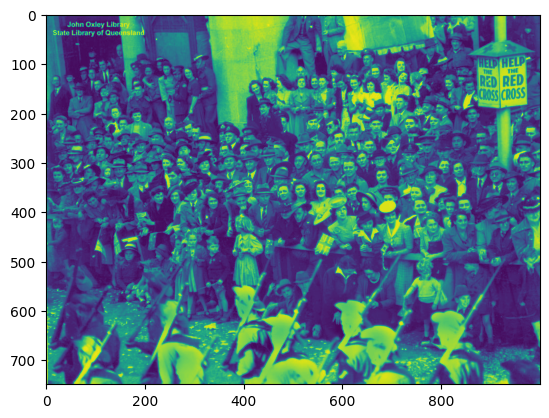

In [9]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

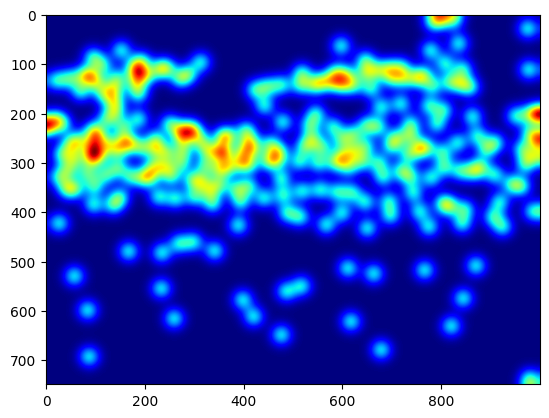

In [10]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [11]:
np.sum(groundtruth)# don't mind this slight variation

248.99999999999991

In [13]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [14]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [15]:
for img_path in img_paths:
    print(img_path)
    # Load the .mat file corresponding to the image
    mat = io.loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_'))
    # Load the image
    img = plt.imread(img_path)
    # Initialize the density map
    k = np.zeros((img.shape[0], img.shape[1]))
    # Extract ground truth data
    gt = mat["image_info"][0, 0][0, 0][0]
    # Populate the density map
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    # Apply Gaussian filter
    k = gaussian_filter(k, 15)
    # Save the density map as an HDF5 file
    with h5py.File(img_path.replace('.jpg', '.h5').replace('images', 'ground_truth'), 'w') as hf:
        hf.create_dataset('density', data=k)

./part_B_final/train_data/images/IMG_160.jpg
./part_B_final/train_data/images/IMG_161.jpg
./part_B_final/train_data/images/IMG_163.jpg
./part_B_final/train_data/images/IMG_165.jpg
./part_B_final/train_data/images/IMG_164.jpg
./part_B_final/train_data/images/IMG_329.jpg
./part_B_final/train_data/images/IMG_110.jpg
./part_B_final/train_data/images/IMG_203.jpg
./part_B_final/train_data/images/IMG_204.jpg
./part_B_final/train_data/images/IMG_201.jpg
./part_B_final/train_data/images/IMG_202.jpg
./part_B_final/train_data/images/IMG_205.jpg
./part_B_final/train_data/images/IMG_147.jpg
./part_B_final/train_data/images/IMG_151.jpg
./part_B_final/train_data/images/IMG_125.jpg
./part_B_final/train_data/images/IMG_111.jpg
./part_B_final/train_data/images/IMG_117.jpg
./part_B_final/train_data/images/IMG_118.jpg
./part_B_final/train_data/images/IMG_115.jpg
./part_B_final/train_data/images/IMG_113.jpg
./part_B_final/train_data/images/IMG_116.jpg
./part_B_final/train_data/images/IMG_114.jpg
./part_B_f

In [ ]:
!python train.py updated_part_A_train.json updated_part_A_val.json 0 0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch 0, processed 0 samples, lr 0.0000001000
Epoch: [0][0/1200]	Time 0.601 (0.601)	Data 0.022 (0.022)	Loss 55.3967 (55.3967)	
Epoch: [0][30/1200]	Time 0.559 (0.528)	Data 0.040 (0.033)	Loss 35.7436 (200.5270)	
Epoch: [0][60/1200]	Time 0.304 (0.498)	Data 0.056 (0.032)	Loss 58.2679 (160.9418)	
Epoch: [0][90/1200]	Time 0.601 (0.498)	Data 0.039 (0.032)	Loss 48.3565 (161.2747)	
E